# 🧠 Deep Learning: ResNet18 per Quality Control

Usiamo **transfer learning** con **ResNet18** pretrained su ImageNet:
- Architettura collaudata e leggera
- Fine-tuning su nostre immagini
- Accelerazione GPU con DirectML (AMD)

Tutto con **PyTorch** e **torchvision** direttamente!

## 📦 Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import json

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights

# Image processing
from PIL import Image

# Sklearn metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

%matplotlib inline
sns.set_style('whitegrid')

print("✅ Imports completati!")
print(f"PyTorch version: {torch.__version__}")

✅ Imports completati!
PyTorch version: 2.4.1+cpu


## 🎮 GPU Setup (DirectML per AMD)

In [2]:
# DirectML per AMD GPU
try:
    import torch_directml
    device = torch_directml.device()
    print(f"✅ DirectML device: {device}")
    print("🚀 AMD GPU acceleration ENABLED!")
except:
    device = torch.device('cpu')
    print("⚠️ DirectML not found, using CPU")

✅ DirectML device: privateuseone:0
🚀 AMD GPU acceleration ENABLED!


## 📂 Configurazione

In [3]:
# Paths
DATA_DIR = Path('../data/raw')
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'
RESULTS_DIR = Path('../results')
RESULTS_DIR.mkdir(exist_ok=True)

# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
IMG_SIZE = 224  # ResNet usa 224x224

print(f"📁 Train dir: {TRAIN_DIR}")
print(f"📁 Test dir: {TEST_DIR}")
print(f"🎯 Batch size: {BATCH_SIZE}")
print(f"📊 Epochs: {NUM_EPOCHS}")

📁 Train dir: ..\data\raw\train
📁 Test dir: ..\data\raw\test
🎯 Batch size: 32
📊 Epochs: 20


## 🖼️ Dataset Class

In [4]:
class CastingDataset(Dataset):
    """Dataset per immagini casting"""
    
    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Carica OK
        ok_dir = self.data_dir / 'ok'
        for img_path in ok_dir.glob('*.jpeg'):
            self.image_paths.append(img_path)
            self.labels.append(0)
        
        # Carica Defective
        def_dir = self.data_dir / 'def_front'
        for img_path in def_dir.glob('*.jpeg'):
            self.image_paths.append(img_path)
            self.labels.append(1)
        
        print(f"Caricati {len(self.image_paths)} immagini")
        print(f"  OK: {self.labels.count(0)}")
        print(f"  Defective: {self.labels.count(1)}")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Carica immagine grayscale
        image = Image.open(img_path).convert('L')
        
        # Converti in RGB (ResNet vuole 3 canali)
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

## 🔄 Data Augmentation & Loading

In [5]:
# Transform per training (con augmentation)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
])

# Transform per test (senza augmentation)
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Crea datasets
print("📥 Caricamento training set...")
train_dataset = CastingDataset(TRAIN_DIR, transform=train_transform)

print("\n📥 Caricamento test set...")
test_dataset = CastingDataset(TEST_DIR, transform=test_transform)

# Crea dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\n✅ DataLoaders pronti!")
print(f"  Train batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")

📥 Caricamento training set...
Caricati 6633 immagini
  OK: 2875
  Defective: 3758

📥 Caricamento test set...
Caricati 715 immagini
  OK: 262
  Defective: 453

✅ DataLoaders pronti!
  Train batches: 208
  Test batches: 23


### Visualizza Batch

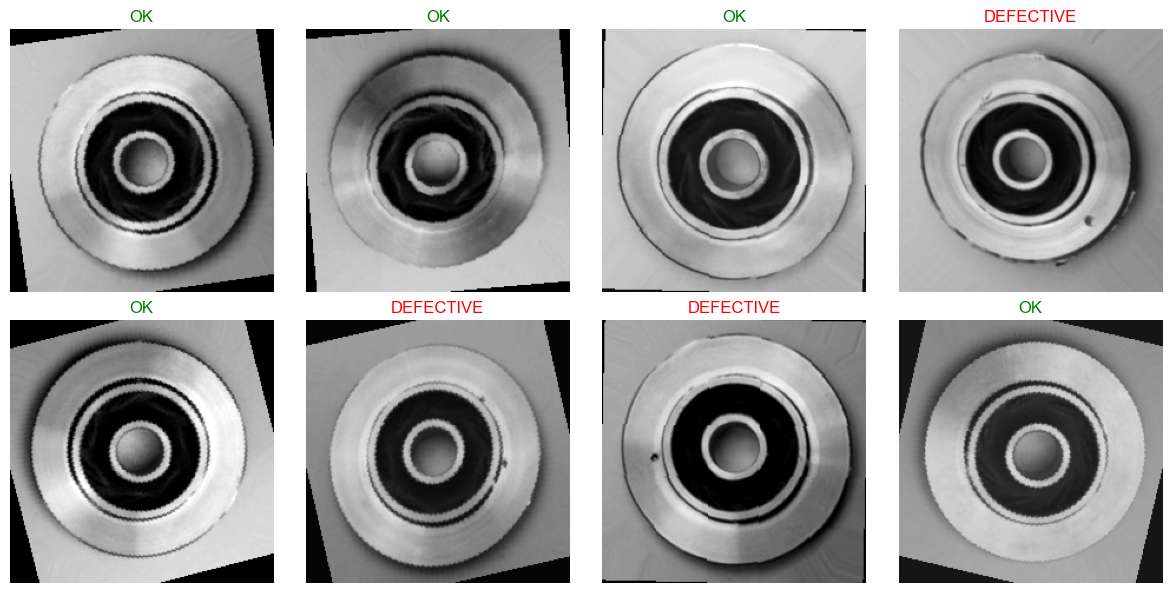

In [6]:
# Prendi un batch
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i in range(8):
    # Denormalize per visualizzazione
    img = images[i].permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    
    axes[i].imshow(img)
    label = 'OK' if labels[i] == 0 else 'DEFECTIVE'
    axes[i].set_title(label, color='green' if labels[i] == 0 else 'red')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 🏗️ Crea Modello ResNet18

Usiamo **weights pretrained** e modifichiamo solo l'ultimo layer

In [7]:
# Carica ResNet18 pretrained
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modifica ultimo layer per 2 classi (ok/defective)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Sposta su GPU
model = model.to(device)

print("✅ ResNet18 caricato con weights pretrained")
print(f"📊 Parametri totali: {sum(p.numel() for p in model.parameters()):,}")
print(f"🔧 Ultimo layer modificato: {num_features} → 2 classi")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\rizzo/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s] 


✅ ResNet18 caricato con weights pretrained
📊 Parametri totali: 11,177,538
🔧 Ultimo layer modificato: 512 → 2 classi


## ⚙️ Loss & Optimizer

In [8]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print(f"✅ Loss: CrossEntropyLoss")
print(f"✅ Optimizer: Adam (lr={LEARNING_RATE})")
print(f"✅ Scheduler: StepLR (step=7, gamma=0.1)")

✅ Loss: CrossEntropyLoss
✅ Optimizer: Adam (lr=0.001)
✅ Scheduler: StepLR (step=7, gamma=0.1)


## 🚀 Training Loop


In [9]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

def train_epoch(model, loader, criterion, optimizer, device):
    """Training per un epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    return running_loss / len(loader), 100 * correct / total

def evaluate(model, loader, criterion, device):
    """Evaluation su test set"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return running_loss / len(loader), 100 * correct / total

# Training!
print("🚀 Inizio training...\n")
best_acc = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    # Update scheduler
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    
    print(f"\n📊 Results:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.2f}%")
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), RESULTS_DIR / 'resnet18_best.pth')
        print(f"  ✅ Best model saved! (Acc: {best_acc:.2f}%)")

print(f"\n🎉 Training completato!")
print(f"🏆 Best test accuracy: {best_acc:.2f}%")

🚀 Inizio training...


Epoch 1/20


Training:   0%|          | 0/208 [00:00<?, ?it/s]c:\Users\rizzo\OneDrive\Desktop\AI\Progetto_Quality_Control\venv\Lib\site-packages\torch\optim\adam.py:534: UserWarning: The operator 'aten::lerp.Scalar_out' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  torch._foreach_lerp_(device_exp_avgs, device_grads, 1 - beta1)
Training: 100%|██████████| 208/208 [00:35<00:00,  5.93it/s, loss=0.0022, acc=95.39%]



📊 Results:
  Train Loss: 0.1252 | Train Acc: 95.39%
  Test Loss:  0.2584 | Test Acc:  90.77%
  ✅ Best model saved! (Acc: 90.77%)

Epoch 2/20


Training: 100%|██████████| 208/208 [00:33<00:00,  6.19it/s, loss=0.0991, acc=98.58%]



📊 Results:
  Train Loss: 0.0475 | Train Acc: 98.58%
  Test Loss:  0.0127 | Test Acc:  99.58%
  ✅ Best model saved! (Acc: 99.58%)

Epoch 3/20


Training: 100%|██████████| 208/208 [00:33<00:00,  6.25it/s, loss=0.0008, acc=98.66%]



📊 Results:
  Train Loss: 0.0440 | Train Acc: 98.66%
  Test Loss:  0.1622 | Test Acc:  95.52%

Epoch 4/20


Training: 100%|██████████| 208/208 [00:33<00:00,  6.25it/s, loss=0.0009, acc=99.17%]



📊 Results:
  Train Loss: 0.0297 | Train Acc: 99.17%
  Test Loss:  0.0186 | Test Acc:  99.44%

Epoch 5/20


Training: 100%|██████████| 208/208 [00:33<00:00,  6.27it/s, loss=0.2830, acc=99.02%]



📊 Results:
  Train Loss: 0.0313 | Train Acc: 99.02%
  Test Loss:  0.0167 | Test Acc:  99.58%

Epoch 6/20


Training: 100%|██████████| 208/208 [00:33<00:00,  6.22it/s, loss=0.6044, acc=98.99%]



📊 Results:
  Train Loss: 0.0368 | Train Acc: 98.99%
  Test Loss:  0.0461 | Test Acc:  98.60%

Epoch 7/20


Training: 100%|██████████| 208/208 [00:33<00:00,  6.23it/s, loss=0.0049, acc=98.85%]



📊 Results:
  Train Loss: 0.0367 | Train Acc: 98.85%
  Test Loss:  0.0436 | Test Acc:  99.02%

Epoch 8/20


Training: 100%|██████████| 208/208 [00:33<00:00,  6.22it/s, loss=0.0222, acc=99.62%]



📊 Results:
  Train Loss: 0.0128 | Train Acc: 99.62%
  Test Loss:  0.0127 | Test Acc:  99.58%

Epoch 9/20


Training: 100%|██████████| 208/208 [00:33<00:00,  6.24it/s, loss=0.0027, acc=99.61%]



📊 Results:
  Train Loss: 0.0124 | Train Acc: 99.61%
  Test Loss:  0.0108 | Test Acc:  99.58%

Epoch 10/20


Training: 100%|██████████| 208/208 [00:34<00:00,  6.07it/s, loss=0.0986, acc=99.67%]



📊 Results:
  Train Loss: 0.0102 | Train Acc: 99.67%
  Test Loss:  0.0105 | Test Acc:  99.72%
  ✅ Best model saved! (Acc: 99.72%)

Epoch 11/20


Training: 100%|██████████| 208/208 [00:34<00:00,  6.05it/s, loss=0.0014, acc=99.67%]



📊 Results:
  Train Loss: 0.0105 | Train Acc: 99.67%
  Test Loss:  0.0096 | Test Acc:  99.72%

Epoch 12/20


Training: 100%|██████████| 208/208 [00:34<00:00,  6.05it/s, loss=0.0003, acc=99.68%]



📊 Results:
  Train Loss: 0.0092 | Train Acc: 99.68%
  Test Loss:  0.0065 | Test Acc:  99.72%

Epoch 13/20


Training: 100%|██████████| 208/208 [00:34<00:00,  6.05it/s, loss=0.0002, acc=99.71%]



📊 Results:
  Train Loss: 0.0089 | Train Acc: 99.71%
  Test Loss:  0.0062 | Test Acc:  99.72%

Epoch 14/20


Training: 100%|██████████| 208/208 [00:34<00:00,  6.07it/s, loss=0.0014, acc=99.62%]



📊 Results:
  Train Loss: 0.0095 | Train Acc: 99.62%
  Test Loss:  0.0054 | Test Acc:  99.86%
  ✅ Best model saved! (Acc: 99.86%)

Epoch 15/20


Training: 100%|██████████| 208/208 [00:34<00:00,  5.99it/s, loss=0.0000, acc=99.76%]



📊 Results:
  Train Loss: 0.0075 | Train Acc: 99.76%
  Test Loss:  0.0050 | Test Acc:  99.86%

Epoch 16/20


Training: 100%|██████████| 208/208 [00:35<00:00,  5.88it/s, loss=0.0000, acc=99.68%]



📊 Results:
  Train Loss: 0.0091 | Train Acc: 99.68%
  Test Loss:  0.0049 | Test Acc:  99.86%

Epoch 17/20


Training: 100%|██████████| 208/208 [00:34<00:00,  6.01it/s, loss=0.0085, acc=99.71%]



📊 Results:
  Train Loss: 0.0080 | Train Acc: 99.71%
  Test Loss:  0.0046 | Test Acc:  99.86%

Epoch 18/20


Training: 100%|██████████| 208/208 [00:34<00:00,  6.07it/s, loss=0.0001, acc=99.74%]



📊 Results:
  Train Loss: 0.0085 | Train Acc: 99.74%
  Test Loss:  0.0047 | Test Acc:  99.86%

Epoch 19/20


Training: 100%|██████████| 208/208 [00:34<00:00,  6.06it/s, loss=0.0108, acc=99.71%]



📊 Results:
  Train Loss: 0.0083 | Train Acc: 99.71%
  Test Loss:  0.0044 | Test Acc:  99.86%

Epoch 20/20


Training: 100%|██████████| 208/208 [00:34<00:00,  6.04it/s, loss=0.0002, acc=99.74%]



📊 Results:
  Train Loss: 0.0075 | Train Acc: 99.74%
  Test Loss:  0.0046 | Test Acc:  99.86%

🎉 Training completato!
🏆 Best test accuracy: 99.86%


## 📈 Plot Training History

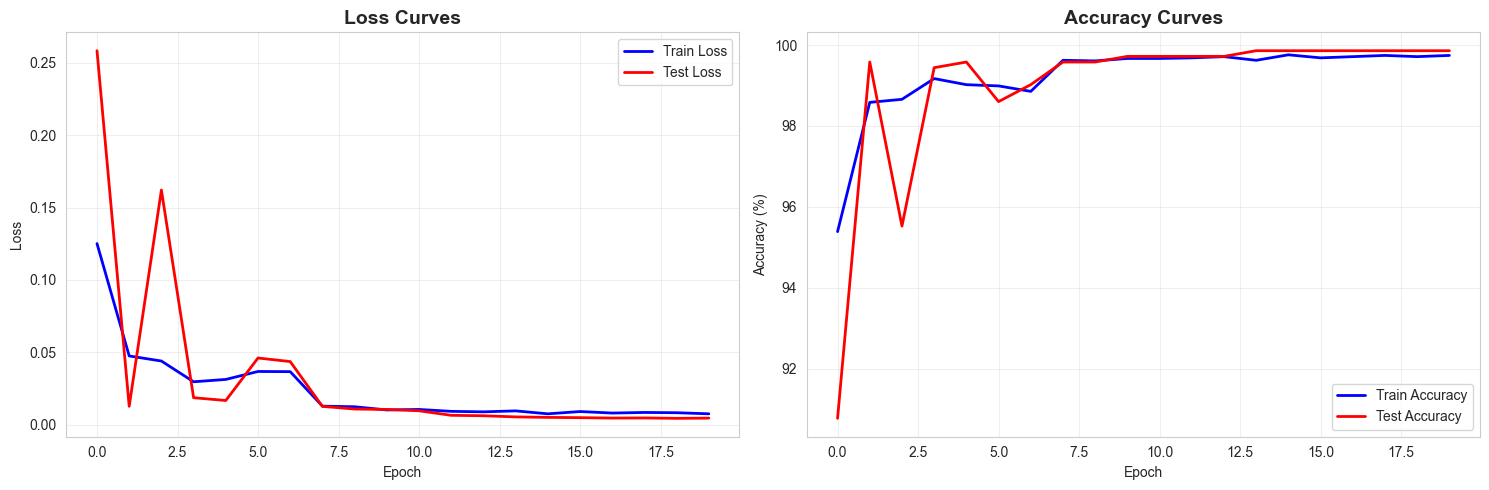

✅ Training curves salvate in: ..\results\resnet18_training.png


In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax1.plot(history['test_loss'], 'r-', label='Test Loss', linewidth=2)
ax1.set_title('Loss Curves', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(history['test_acc'], 'r-', label='Test Accuracy', linewidth=2)
ax2.set_title('Accuracy Curves', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'resnet18_training.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Training curves salvate in: {RESULTS_DIR / 'resnet18_training.png'}")

## 📊 Valutazione Finale

In [11]:
# Carica best model
model.load_state_dict(torch.load(RESULTS_DIR / 'resnet18_best.pth'))
model.eval()

# Predizioni complete
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Metriche
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print("📈 Performance su Test Set:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall:    {rec:.4f}")
print(f"  F1 Score:  {f1:.4f}")

print("\n" + classification_report(all_labels, all_preds, target_names=['OK', 'Defective']))

C:\Users\rizzo\AppData\Local\Temp\ipykernel_25420\2175997073.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(RESULTS_DIR / 'resnet18_bes

📈 Performance su Test Set:
  Accuracy:  0.9986
  Precision: 1.0000
  Recall:    0.9978
  F1 Score:  0.9989

              precision    recall  f1-score   support

          OK       1.00      1.00      1.00       262
   Defective       1.00      1.00      1.00       453

    accuracy                           1.00       715
   macro avg       1.00      1.00      1.00       715
weighted avg       1.00      1.00      1.00       715



## 🎨 Confusion Matrix

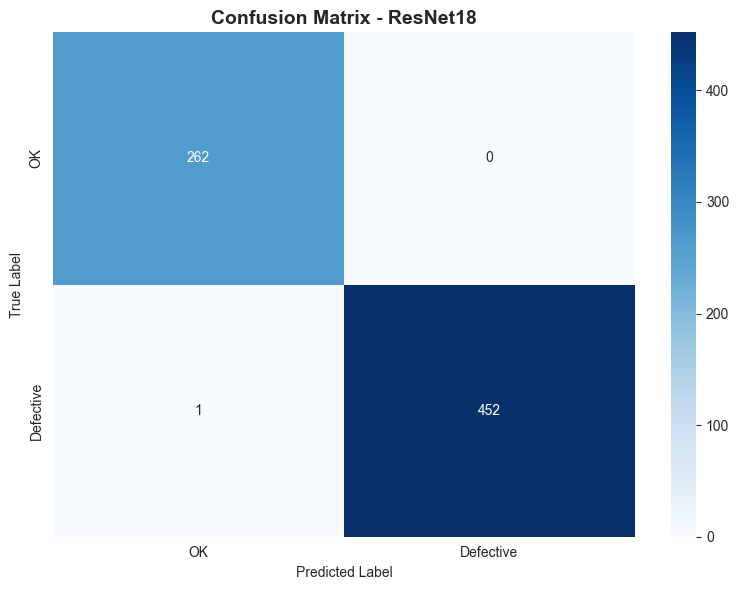

✅ Confusion matrix salvata in: ..\results\resnet18_confusion_matrix.png


In [12]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['OK', 'Defective'],
            yticklabels=['OK', 'Defective'])
plt.title('Confusion Matrix - ResNet18', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'resnet18_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Confusion matrix salvata in: {RESULTS_DIR / 'resnet18_confusion_matrix.png'}")

## 💾 Salva Risultati

In [13]:
results = {
    'accuracy': float(acc),
    'precision': float(prec),
    'recall': float(rec),
    'f1_score': float(f1),
    'best_test_acc': float(best_acc),
    'hyperparameters': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS
    }
}

with open(RESULTS_DIR / 'resnet18_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print(f"✅ Risultati salvati in: {RESULTS_DIR / 'resnet18_results.json'}")
print(f"✅ Modello salvato in: {RESULTS_DIR / 'resnet18_best.pth'}")

✅ Risultati salvati in: ..\results\resnet18_results.json
✅ Modello salvato in: ..\results\resnet18_best.pth


## 🎉 Fine!

Hai trainato ResNet18 con:
- ✅ Transfer learning da ImageNet
- ✅ Fine-tuning su dataset casting
- ✅ GPU acceleration (DirectML)
- ✅ Data augmentation

**Confronta i risultati** con SVM da `01_svm_baseline.ipynb`! 🚀